In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from data import read_preprocessed_data
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
import seaborn as sns

color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


In [35]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

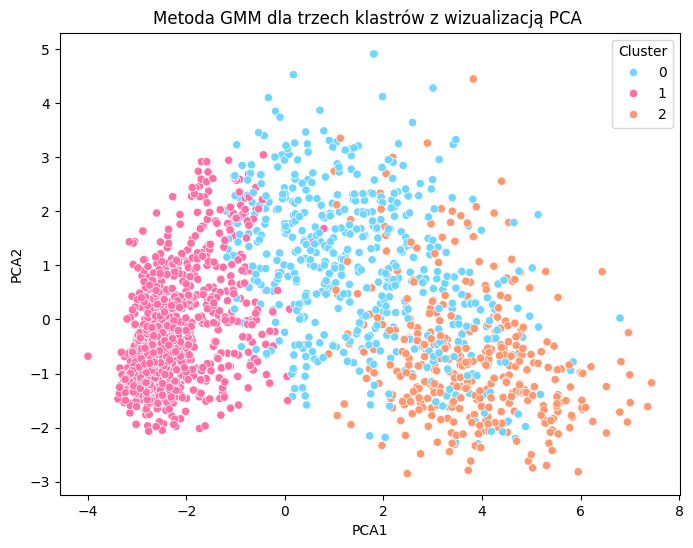

In [36]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [37]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.45
PCA2:  0.1
Suma wyjaśnionej wariancji:  0.55


In [38]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,62714.003466,35209.285038,75862.637532
Kidhome,0.10052,0.774621,0.023136
Teenhome,0.731369,0.473485,0.200514
Recency,46.994801,49.303977,50.948586
MntWines,446.523397,49.409091,655.305913
MntFruits,35.561102,5.466856,65.813107
MntMeatProducts,169.511265,26.340909,494.977425
MntFishProducts,48.767474,8.214962,98.854594
MntSweetProducts,36.259827,5.573864,67.52711
MntGoldProds,65.435714,17.139205,72.822155


In [39]:
 #model mieszanin gaussa
data_scaled = read_preprocessed_data()
gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Text(0.5, 1.0, 'Metoda GMM dla czterech klastrów z wizualizacją PCA ')

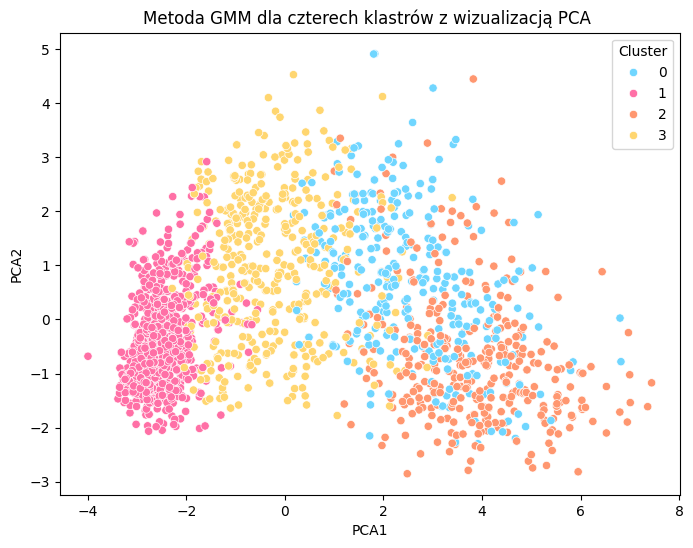

In [40]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete
)
plt.title("Metoda GMM dla czterech klastrów z wizualizacją PCA ")

In [41]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.45
PCA2:  0.1
Suma wyjaśnionej wariancji:  0.55


In [42]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów
cluster_summary.transpose()


c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,67816.960843,32255.16088,75740.359788,53267.868304
Kidhome,0.093373,0.869213,0.02381,0.209821
Teenhome,0.653614,0.41088,0.203704,0.783482
Recency,47.177711,48.863426,50.018519,49.580357
MntWines,553.599398,30.177083,645.767196,247.245536
MntFruits,48.732772,4.454861,65.996192,15.442441
MntMeatProducts,214.204819,19.523148,504.056134,88.511161
MntFishProducts,63.511864,6.171296,100.101685,24.58012
MntSweetProducts,47.971913,4.295139,67.636391,17.570837
MntGoldProds,73.983687,13.711806,73.847637,44.328648


In [43]:
#minmax

In [44]:
data_scaled = read_preprocessed_data(std=False, minmax=True)

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


In [45]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

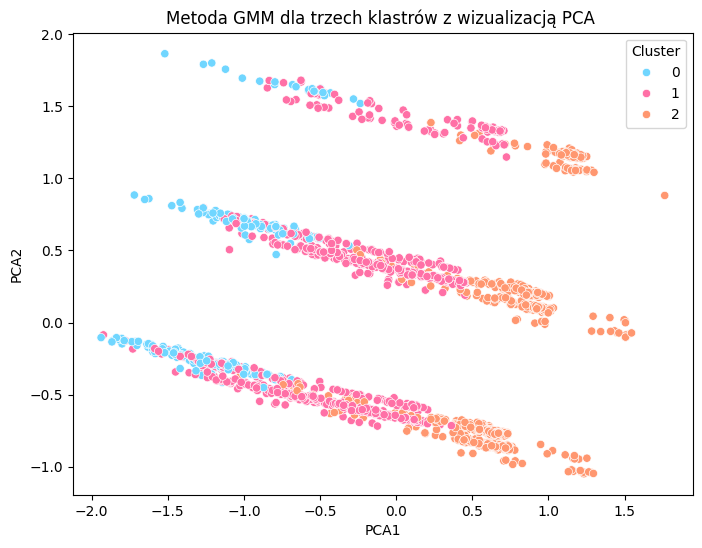

In [46]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [47]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.25
PCA2:  0.19
Suma wyjaśnionej wariancji:  0.44


In [48]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,77590.872727,55688.374029,37074.274232
Kidhome,0.0,0.0,1.046099
Teenhome,0.065455,0.687014,0.429078
Recency,49.647273,48.508324,49.22104
MntWines,597.687273,369.391787,79.843972
MntFruits,61.558935,31.443809,7.840988
MntMeatProducts,597.968067,133.150943,39.905437
MntFishProducts,101.422858,42.12143,11.141342
MntSweetProducts,62.022274,32.821133,7.621749
MntGoldProds,72.625229,53.318854,19.114657


In [49]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

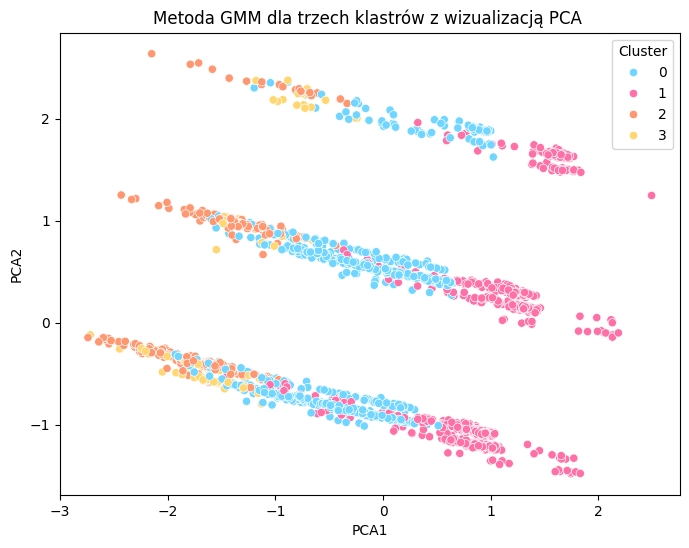

In [50]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [51]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.35
PCA2:  0.27
Suma wyjaśnionej wariancji:  0.61


In [52]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,53152.580563,37074.274232,77590.872727,72352.159664
Kidhome,0.0,1.046099,0.0,0.0
Teenhome,0.719949,0.429078,0.065455,0.470588
Recency,48.16624,49.22104,49.647273,50.756303
MntWines,351.78133,79.843972,597.687273,485.117647
MntFruits,22.274811,7.840988,61.558935,91.697221
MntMeatProducts,115.080563,39.905437,597.968067,251.89916
MntFishProducts,31.871851,11.141342,101.422858,109.475802
MntSweetProducts,19.861893,7.621749,62.022274,117.981854
MntGoldProds,47.238299,19.114657,72.625229,93.276789
